## Install Necessary Libraries ##

In [24]:
## ONCE DETECTRON2 IS INSTALLED, PLEASE COPY THE CONTENTS FROM THE SUBFOLDER DETECTRON2 FOLDER TO THE MAIN DETECTRON2 FOLDER!!!

# Upgrade pip
%pip install --upgrade pip

# Install OpenCV for image processing
%pip install opencv-python

# Install numpy at the desired version
%pip install numpy==1.26.1

# Install PyTorch and related packages (adjust versions/URLs as needed for your platform)
%pip install torch torchvision torchaudio

# Install gitpython and cython if not already installed
%pip install gitpython cython

# Install dependencies, but pin fvcore and pycocotools to compatible versions:
%pip install cython

# Uninstall any existing fvcore (which may be too new) and install a compatible version.
!pip uninstall -y fvcore
%pip install fvcore==0.1.5.post20221221

# Uninstall any existing pycocotools and install a compatible version.
!pip uninstall -y pycocotools
%pip install pycocotools==2.0.8

# ---- Additional installations ----
%pip install docutils==0.19
%pip install sphinx==7
%pip install recommonmark==0.6.0
%pip install sphinx_rtd_theme
%pip install termcolor
%pip install yacs
%pip install tabulate
%pip install cloudpickle
%pip install future
# (The following two lines with CPU wheels are for Linux CP37; comment them out if not needed)
# %pip install https://download.pytorch.org/whl/cpu/torch-1.8.1%2Bcpu-cp37-cp37m-linux_x86_64.whl
# %pip install https://download.pytorch.org/whl/cpu/torchvision-0.9.1%2Bcpu-cp37-cp37m-linux_x86_64.whl
%pip install "omegaconf>=2.1.0.dev24"
%pip install "hydra-core>=1.1.0.dev5"
%pip install scipy
%pip install timm
# ---------------------------------

# Clone the Detectron2 repository and install it in editable mode
import os
if not os.path.exists('detectron2'):
    !git clone https://github.com/facebookresearch/detectron2.git

%cd detectron2
%pip install -e
%cd ..

# Install TensorFlow and Keras for deep learning models
%pip install tensorflow

# Install pickleshare to fix the IPython warning
%pip install pickleshare

# Install additional required libraries
%pip install numpy matplotlib pandas scikit-learn tqdm Pillow

# Install geospatial libraries
%pip install geopandas rasterio shapely

# Install any other utility libraries if needed
%pip install jsonschema pyyaml

# Install IPython kernel to ensure compatibility
%pip install ipykernel

# After installations, you may need to restart the kernel
print("All libraries installed. Please restart the kernel to ensure all packages are loaded.")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you 

## Import Necessary Libraries ##

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import random
import glob



import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input

from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator
print(np.__version__)



1.26.1


## Implement get_roof_dicts() ##

In [25]:
def get_roof_dicts(img_dir):
    dataset_dicts = []
    img_files = sorted(glob.glob(os.path.join(img_dir, "images", "*.tif")))
    
    for idx, img_path in enumerate(img_files):
        mask_path = img_path.replace("images", "gt")  # or some other logic if needed
        
        height, width = cv2.imread(img_path).shape[:2]
        
        record = {
            "file_name": img_path,
            "image_id": idx,
            "height": height,
            "width": width,
        }
        
        # Read mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        objs = []
        for contour in contours:
            # Flatten the contour
            coords = contour.flatten().tolist()
            
            # Skip degenerate polygons
            if len(coords) < 6:  # fewer than 3 points
                continue
            
            xs = coords[0::2]
            ys = coords[1::2]
            x_min, x_max = min(xs), max(xs)
            y_min, y_max = min(ys), max(ys)
            
            bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
            
            # **Important**: double brackets around coords
            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": [coords],  # nested list
                "category_id": 0
            }
            objs.append(obj)
        
        record["annotations"] = objs
        dataset_dicts.append(record)
    
    return dataset_dicts

## Register the dataset for Detectron2 ##

In [26]:
dataset_root = r"/Users/ericdayan/AerialImageDataset/" # Change this to your dataset path

for d in ["train", "val"]:
    dataset_dir = os.path.join(dataset_root, d)
    DatasetCatalog.register(
        f"roof_{d}",
        lambda d=d: get_roof_dicts(os.path.join(dataset_root, d))
    )
    MetadataCatalog.get(f"roof_{d}").set(thing_classes=["roof"])

roof_metadata = MetadataCatalog.get("roof_train")
dataset_dicts = get_roof_dicts(os.path.join(dataset_root, "train"))
print("Number of records in dataset:", len(dataset_dicts))


Number of records in dataset: 180


## Visualize sample data to ensure it's loaded correctly ##

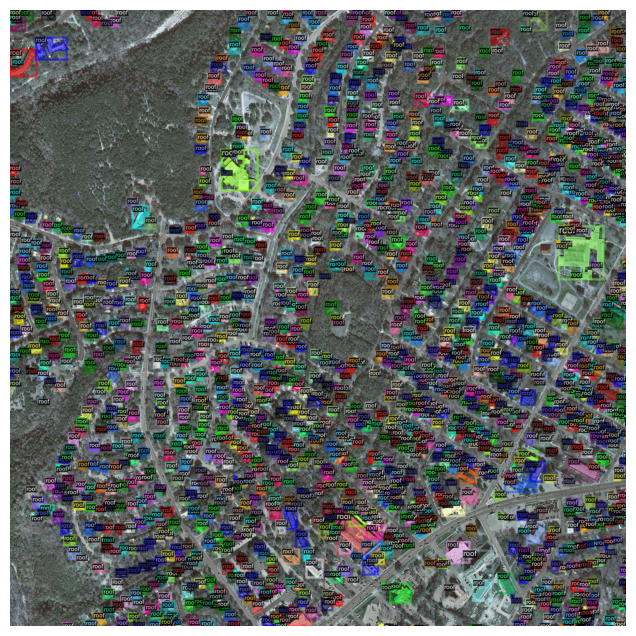

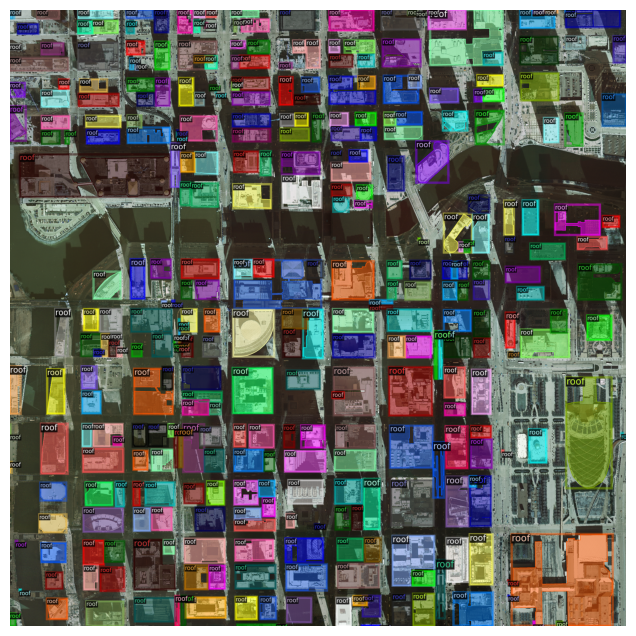

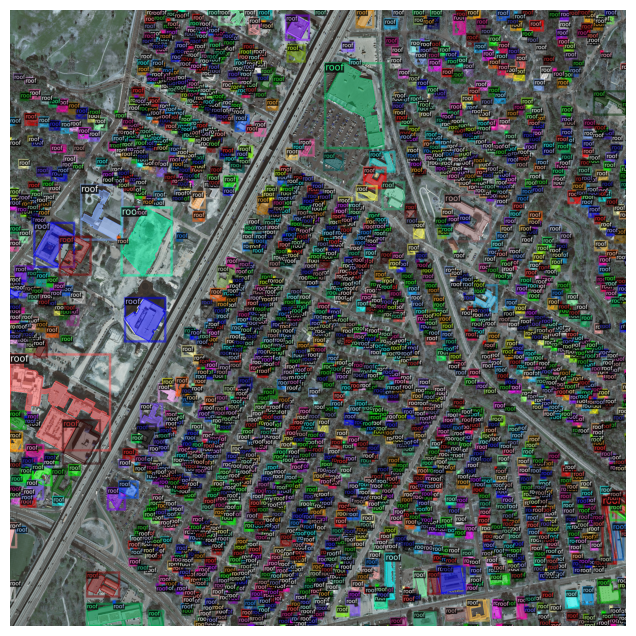

In [27]:
%matplotlib inline
# Randomly pick a few images
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    
    visualizer = Visualizer(img[:, :, ::-1], metadata=roof_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()



## Configure and train the Mask R-CNN model ##

In [ ]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """
        Create evaluator for a given dataset.
        The COCOEvaluator will compute mAP and other metrics on a COCO-formatted dataset.
        """
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Build the configuration
cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)

# Specify our registered datasets:
cfg.DATASETS.TRAIN = ("roof_train",)
cfg.DATASETS.TEST = ("roof_val",)

# Standard parameters
cfg.DATALOADER.NUM_WORKERS = 8       # adjust to number of CPU cores
cfg.SOLVER.IMS_PER_BATCH = 2         # images per batch
cfg.SOLVER.BASE_LR = 0.00025         # learning rate
cfg.SOLVER.MAX_ITER = 5000           # number of iterations (consider increasing this if needed)

# Only one class: 'roof'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# Download weights from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)

# Force CPU usage, comment out if you have an NVIDIA GPU
cfg.MODEL.DEVICE = "cpu"

# Create output folder if it does not exist
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Initialize the trainer using our subclass that includes an evaluator
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

## Randomly select test image ##

In [ ]:
# Change to you path for test images
test_images_dir = r"C:\Users\maxxr\Desktop\AerialImageDataset\test\images"  

# Valid image extensions
img_extensions = [".jpg", ".jpeg", ".png", ".tif"]
all_test_files = [
    f for f in os.listdir(test_images_dir)
    if os.path.splitext(f)[1].lower() in img_extensions
]

if not all_test_files:
    raise ValueError("No valid images found in test_images_dir!")

# Randomly pick one
chosen_file = random.choice(all_test_files)
test_image_path = os.path.join(test_images_dir, chosen_file)

print("Randomly chosen test image:", test_image_path)


## Perform inference using the trained model and visualize ##

In [ ]:
# Create a new config for inference
inf_cfg = get_cfg()
inf_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Match the training setup (1 class)
inf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
inf_cfg.MODEL.DEVICE = "cpu"  # use "cuda" if applicable

# Point to the trained weights (model_final.pth should be generated in cfg.OUTPUT_DIR by training)
inf_cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# Set a threshold for predictions (adjust as needed)
inf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

# Create the predictor
predictor = DefaultPredictor(inf_cfg)

# Read the randomly chosen test image
test_image = cv2.imread(test_image_path)
if test_image is None:
    raise ValueError("Failed to read test image: " + test_image_path)

# Run inference
outputs = predictor(test_image)

# Retrieve metadata for visualization (ensure your dataset registration set thing_classes=["roof"])
roof_metadata = MetadataCatalog.get("roof_train")  # or "roof_val" if that's how you registered it

# Visualize predictions on the test image
v = Visualizer(test_image[:, :, ::-1], metadata=roof_metadata, scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(12, 8))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()


## Prepare data generators for roof type classification ##

In [ ]:
# Define directories
train_dir = 'path/to/roof_type/train'
val_dir = 'path/to/roof_type/val'

# Image data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)


## Build and train the roof type classification model ##

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)


Files exist
White pixels in original segmentation mask: 4680659
White pixels in processed mask (obstacles removed): 4244168
White area in square meters: 118628.72 m²
White area in square kilometers: 0.119 km²


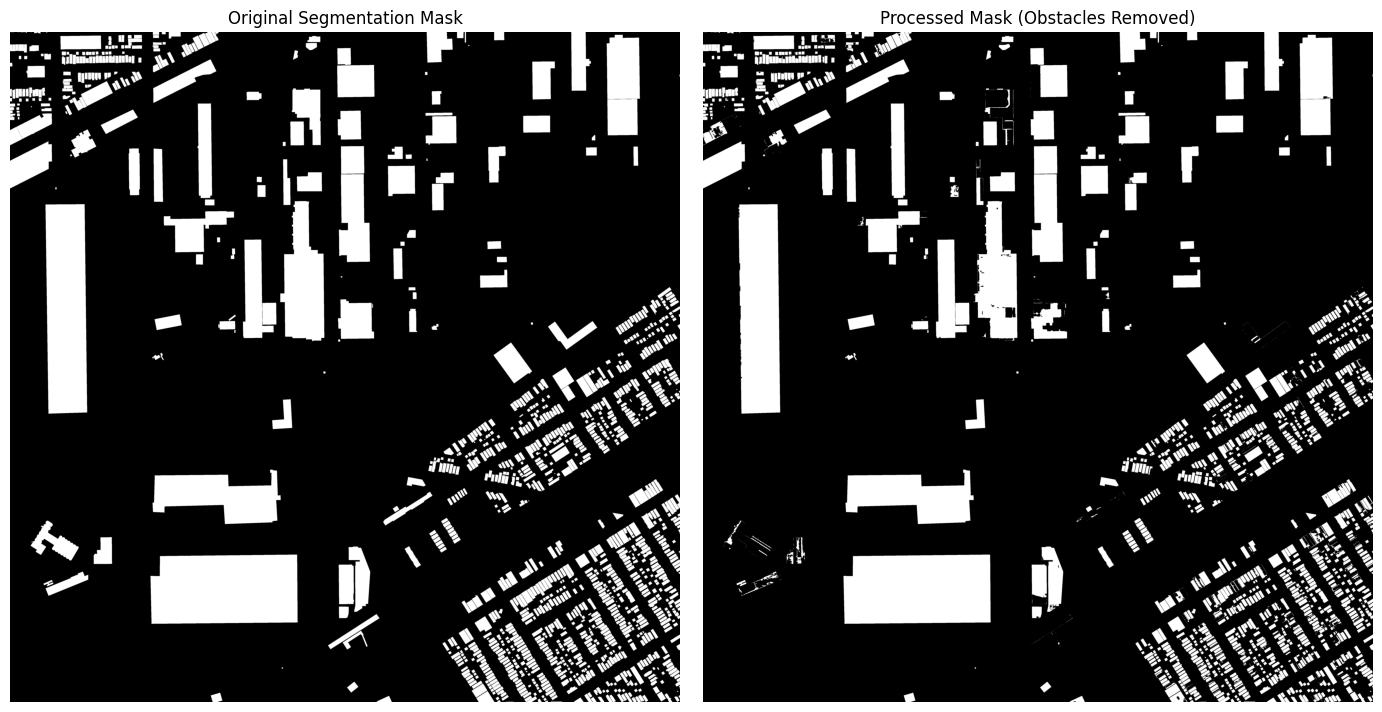

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths to the image and segmentation mask
image_path = '/Users/ericdayan/AerialImageDataset/train/images/chicago20.tif'
mask_path = '/Users/ericdayan/AerialImageDataset/train/gt/chicago20.tif'

# Physical dimensions of the picture in meters
physical_width_m = 986.58
physical_height_m = 708.28

if os.path.exists(image_path) and os.path.exists(mask_path):
    print("Files exist")
    # Load the original image and segmentation mask (houses in white, background in black)
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, 0)
    
    # Create an empty final mask (all black) to hold the processed usable roof areas
    final_mask = np.zeros_like(mask)
    
    # Find all house contours (each white region in the segmentation mask is assumed to be a house)
    house_contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if house_contours:
        for house_contour in house_contours:
            # Calculate bounding box for the current house
            x, y, w, h = cv2.boundingRect(house_contour)
            
            # Zoom into the roof and corresponding mask area using the original mask
            largest_roof = image[y:y+h, x:x+w]
            roof_mask = mask[y:y+h, x:x+w]
            
            # Apply the mask to the roof area to isolate it
            masked_roof = cv2.bitwise_and(largest_roof, largest_roof, mask=roof_mask)
            
            # Convert masked roof to grayscale and then to binary
            gray_masked_roof = cv2.cvtColor(masked_roof, cv2.COLOR_BGR2GRAY)
            blurred_roof = cv2.GaussianBlur(gray_masked_roof, (5, 5), 0)
            _, binary_mask = cv2.threshold(blurred_roof, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Find contours within the masked area from the binary mask
            contours_in_roof, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Create an image to draw the filled contours (obstacles)
            filled_contours_img = np.zeros_like(masked_roof)
            
            # Define area thresholds to filter out false detections:
            min_obstacle_area = 50
            max_obstacle_area = (w * h) * 0.3  # Adjust this fraction based on your data
            
            filtered_contours = []
            for cnt in contours_in_roof:
                area = cv2.contourArea(cnt)
                if min_obstacle_area < area < max_obstacle_area:
                    filtered_contours.append(cnt)
            
            # Draw and fill the filtered contours with green (using your exact code)
            cv2.drawContours(filled_contours_img, filtered_contours, -1, (0, 255, 0), thickness=cv2.FILLED)
            
            # Convert the filled contours image to grayscale, then threshold to obtain a binary obstacle mask
            filled_contours_gray = cv2.cvtColor(filled_contours_img, cv2.COLOR_BGR2GRAY)
            _, obstacle_mask = cv2.threshold(filled_contours_gray, 1, 255, cv2.THRESH_BINARY)
            # Invert the obstacle mask so that obstacles become black
            obstacle_mask_inv = cv2.bitwise_not(obstacle_mask)
            
            # Remove obstacles from the original roof mask (usable roof area remains white)
            processed_roof_mask = cv2.bitwise_and(roof_mask, obstacle_mask_inv)
            
            # Merge the processed roof mask into the final mask at the proper location
            final_mask[y:y+h, x:x+w] = cv2.bitwise_or(final_mask[y:y+h, x:x+w], processed_roof_mask)
        
        # Count white pixels in both the original and processed masks
        original_white_pixels = cv2.countNonZero(mask)
        processed_white_pixels = cv2.countNonZero(final_mask)
        print("White pixels in original segmentation mask:", original_white_pixels)
        print("White pixels in processed mask (obstacles removed):", processed_white_pixels)
        
        # Get the pixel dimensions of the mask
        mask_height, mask_width = final_mask.shape  # height and width in pixels
        
        # Calculate the area each pixel represents.
        # Each pixel's physical width: physical_width_m / mask_width
        # Each pixel's physical height: physical_height_m / mask_height
        area_per_pixel = (physical_width_m / mask_width) * (physical_height_m / mask_height)
        
        # Total white area (usable roof area) in square meters and square kilometers:
        white_area_sqm = processed_white_pixels * area_per_pixel
        white_area_sqkm = white_area_sqm / 1e6
        
        print("White area in square meters: {:.2f} m²".format(white_area_sqm))
        print("White area in square kilometers: {:.3f} km²".format(white_area_sqkm))
        
        # Display the original segmentation mask and the final processed mask side by side
        plt.figure(figsize=(14, 7))
        plt.subplot(1, 2, 1)
        plt.imshow(mask, cmap='gray')
        plt.title("Original Segmentation Mask")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(final_mask, cmap='gray')
        plt.title("Processed Mask (Obstacles Removed)")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No houses detected in the segmentation mask.")
else:
    print("Files do not exist, check the paths")



## Perform obstacle detection using edge detection and color thresholding ##

## Calculate the effective roof area excluding obstacles ##

In [21]:
# Assume roof_mask is a binary mask of the roof area
roof_mask = cv2.imread('/Users/ericdayan/Documents/Documents/University/Capstone/Object Detection.coco/train/img2736_png.rf.58fc1effe9f0eaa92764b325baf93979.jpg', cv2.IMREAD_GRAYSCALE)
roof_area_pixels = cv2.countNonZero(roof_mask)

# Obstacle area in pixels
obstacle_area_pixels = cv2.countNonZero(combined_mask)

# Effective area in pixels
effective_area_pixels = roof_area_pixels - obstacle_area_pixels

# Spatial resolution in meters per pixel (you need to define this based on your data)
resolution = 0.2  # Example: each pixel represents 0.1 meters

# Convert to square meters
effective_area_m2 = effective_area_pixels * (resolution ** 2)

print(f"Effective roof area available for solar panels: {effective_area_m2:.2f} square meters")


Effective roof area available for solar panels: 7066.25 square meters


## Detect roof faces and calculate orientation angles ##

In [12]:
# Load the roof image
roof_image = cv2.imread('path/to/roof_image.jpg')
gray = cv2.cvtColor(roof_image, cv2.COLOR_BGR2GRAY)

# Apply edge detection
edges = cv2.Canny(gray, threshold1=50, threshold2=150)

# Use Hough Line Transform to detect lines
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)

# Create an empty image to draw lines
line_image = np.zeros_like(roof_image)

# Draw lines on the image
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Overlay lines on the original image
overlay_image = cv2.addWeighted(roof_image, 0.8, line_image, 1, 0)

# Display the image with detected lines
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Roof Faces')
plt.show()

# Placeholder for normal vector calculation
# In reality, you would need 3D coordinates of the roof faces
# For demonstration, let's assume a normal vector
normal_vector = np.array([0.5, 0.5, 0.7071])  # Example normal vector

# Function to calculate orientation
import math

def calculate_orientation(normal_vector):
    nx, ny, nz = normal_vector
    azimuth = math.degrees(math.atan2(ny, nx)) % 360
    tilt = math.degrees(math.acos(nz / np.linalg.norm(normal_vector)))
    return azimuth, tilt

azimuth_angle, tilt_angle = calculate_orientation(normal_vector)

print(f"Azimuth Angle: {azimuth_angle:.2f} degrees")
print(f"Tilt Angle: {tilt_angle:.2f} degrees")


[ WARN:0@1562.491] global loadsave.cpp:268 findDecoder imread_('path/to/roof_image.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


## Determine if the roof face is suitable for solar panel installation ##

In [ ]:
if 30 <= tilt_angle <= 40:
    print("The roof face has an ideal tilt angle for solar panels.")
    suitable_area_m2 = effective_area_m2  # Assuming the entire effective area is suitable
else:
    print("The roof face does not have an ideal tilt angle for solar panels.")
    suitable_area_m2 = 0

print(f"Suitable area for solar panels: {suitable_area_m2:.2f} square meters")


## Estimate potential energy production ##

In [ ]:
# Assuming average solar irradiance and panel efficiency
solar_irradiance = 1000  # W/m^2 (average peak sun hours)
panel_efficiency = 0.17  # 17% efficiency
system_losses = 0.14     # 14% losses

# Calculate the estimated energy production
daily_energy_kWh = suitable_area_m2 * solar_irradiance * panel_efficiency * (1 - system_losses) * 4 / 1000

print(f"Estimated daily energy production: {daily_energy_kWh:.2f} kWh")
